In [230]:
import torch as t
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import pandas as pd
import math

__Задание 1__
Градиент в PyTorch

In [231]:
x = t.tensor(2., requires_grad=True)

y = 3 * x ** 2 + 4 * x + 1
print("Function at x:", y)
y.backward()
print("Derivative at x:", x.grad)

y = 3 * x + 5
print("Function at x:", y)
y.backward()
print("Derivative at x:", x.grad)

Function at x: tensor(21., grad_fn=<AddBackward0>)
Derivative at x: tensor(16.)
Function at x: tensor(11., grad_fn=<AddBackward0>)
Derivative at x: tensor(19.)


In [132]:
def draw(fun, bounds=(-10, 10), points=100):
    x_points = t.linspace(bounds[0], bounds[1], points, requires_grad=True)
    y_points = fun(x_points)
    t.sum(y_points).backward()  # to force all backward
    derivative_points = x_points.grad

    plt.plot(x_points.detach().numpy(), y_points.detach().numpy(), label='Function')
    plt.plot(x_points.detach().numpy(), derivative_points.detach().numpy(), label='Derivative')
    plt.legend()

    plt.show()


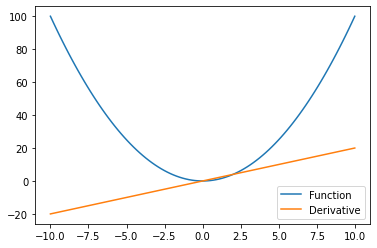

In [133]:
draw(lambda x: x ** 2)

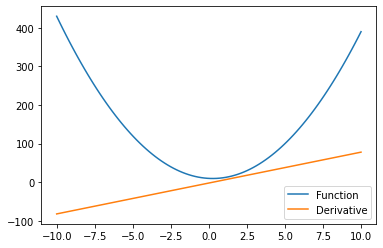

In [134]:
draw(lambda x: 4 * x ** 2 - 2 * x + 10)

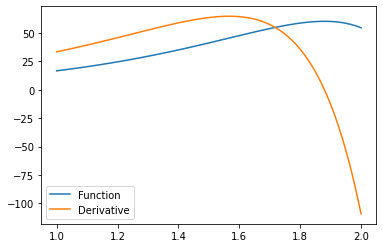

In [222]:
draw(lambda x: 3 * t.exp(2 * x) + -2 * t.exp(x ** 2), (1, 2))

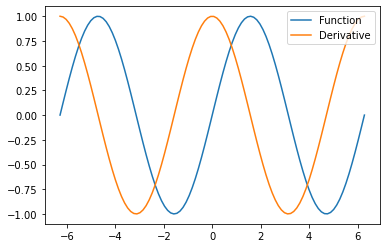

In [136]:
draw(lambda x: t.sin(x), (-2 * t.pi, 2 * t.pi))

__Задание 2__

In [225]:
class LinearData:
    def __init__(self, epoch : int, lr : float, a : float, b : float):
        self.epoch = epoch
        self.lr = lr
        self.a = a
        self.b = b

class LinearRegression:

    def __init__(self, fun,  batch : int, dim_in : int, dim_out : int,
                 eps : int = 20, in_feat : int = 1, out_feat : int = 1):

        self.input_X = t.randn(batch, dim_in, requires_grad=True)
        self.output_Y = self.make_noise(fun(self.input_X), dim_out, batch).detach()
        self.output_Y.requires_grad_(True)
        self.eps = eps
        self.fun = t.nn.MSELoss(reduction='sum')
        self.model = self.get_model(in_feat, out_feat)

    @staticmethod
    def make_noise(tensor : t.Tensor, dim :int, bs : int) -> t.Tensor:
        return tensor + t.randn(bs, dim)

    @staticmethod
    def get_model(in_feat : int = 1, out_feat : int = 1):
        return t.nn.Linear(in_feat, out_feat)

    def get_sum_distance(self) -> float:
        predictions = self.model(self.input_X)
        return self.fun(predictions, self.output_Y).item()

    def sgd(self, lr : float) -> LinearData:
        optimizer = t.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        cur_epoch = 0
        distance = self.get_sum_distance()
        while distance > self.eps:
            optimizer.zero_grad()
            pred_y = self.model(self.input_X)
            loss = self.fun(pred_y, self.output_Y)
            distance = loss.item()
            loss.backward()
            optimizer.step()
            cur_epoch += 1
        return LinearData(cur_epoch, lr, list(self.model.parameters())[0].data[0, 0],
                                        list(self.model.parameters())[1].data[0])

def get_table(lr_list : list, fun, bs : int, d_in : int, d_out : int):
    lrs = []
    epochs = []
    for lr in lr_list:
        linear = LinearRegression(fun, bs, d_in, d_out)
        linear_data = linear.sgd(lr)
        lrs.append(linear_data.lr)
        epochs.append(linear_data.epoch)
    ans = pd.DataFrame()
    ans["Linear Rate"] = lrs
    ans["Epochs"] = epochs
    return ans

def show_result(lr : float, fun, bs : int, d_in : int, d_out : int):
    linear = LinearRegression(fun, bs, d_in, d_out)
    x = linear.input_X.detach().numpy()
    y = linear.output_Y.detach().numpy()
    plt.scatter(x, y)
    linear_data = linear.sgd(lr)
    x = np.linspace(-10, 10)
    y = linear_data.a * x + linear_data.b
    plt.plot(x, y)
    plt.show()


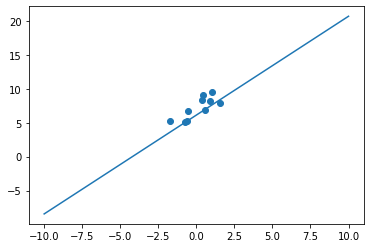

In [226]:
show_result(0.0002, lambda x : 2 * x + 7, 10, 1, 1)


In [227]:
get_table([i for i in np.arange(0.0001, 0.0005, 0.0001)],
          lambda x : 2 * x + 7, 10, 1, 1)


,Linear Rate,Epochs
0,0.0001,88
1,0.0002,41
2,0.0003,33
3,0.0004,23


__Задание 3__
SciPy с градиентом из PyTorch

In [236]:
def get_parabola():
    def fun(x, p):
        [a, b, c] = p
        return a * (x ** 2) + b * x + c

    def grad(x):
        return np.array([lambda _: x ** 2,
                         lambda _: x,
                         lambda _: 1])

    return fun, grad


def noise(y, error):
    return y * (1 + np.random.uniform(-error, error))


def make_sample(f, number_of_point, bounds, error):
    (l, r) = bounds
    x = np.random.uniform(l, r, number_of_point)
    return [(xi, noise(f(xi), error)) for xi in x]


def test_torch_grad(fun_x_p, init_params, first_point, error=0.1, bounds=(-10, 10), points=100):
    first_point = np.array(first_point)

    def init_fun(x): return fun_x_p(x, init_params)

    x = t.linspace(bounds[0], bounds[1], points)
    y = noise(init_fun(x), error)

    def fun(p):
        p = t.tensor(p, requires_grad=True)
        return p, t.sum((fun_x_p(x, p) - y) ** 2)

    def optim_fun(p):
        p, sum = fun(p)
        return sum.detach().numpy()

    def grad(p):
        p, sum = fun(p)
        sum.backward()
        return p.grad

    return optimize.minimize(optim_fun, first_point, jac=grad, tol=1e-5, method='BFGS')


parabola, _ = get_parabola()
test_torch_grad(parabola, [3., 3., 5.], [2., 3., 4.], error=0.4, points=100)

      fun: 3.923446456610691e-09
 hess_inv: array([[ 5.40603979e-06, -6.43393054e-11, -1.83841458e-04],
       [-6.43393054e-11,  1.47029736e-04,  2.97163136e-09],
       [-1.83841458e-04,  2.97163136e-09,  1.12518337e-02]])
      jac: array([1.50764373e-03, 6.74312469e-06, 9.34600830e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 33
      nit: 3
     njev: 21
   status: 2
  success: False
        x: array([2.52644656, 2.52644657, 4.21074415])

__Задание 3__
Сравнение SciPy и ранее реализованных методов

In [216]:
EPS = 1e-3
ERR_EPS = 1.3e1
GRAD_ERR = 1e3
MAX_EPOCH = 100


def distance(x, y):
    return np.linalg.norm(x - y)


def abstract_descent_by_dir(first_point: np.matrix, next_point_fun: callable, stop_criteria: callable, callback=None):
    if not callback:
        callback = lambda ig, nore: None
    points = np.array([first_point])
    current_point = first_point
    epoch = 0
    while not stop_criteria(current_point) and epoch < MAX_EPOCH:
        next_point = next_point_fun(current_point)
        points = np.append(points, [next_point], axis=0)
        callback(current_point, next_point)
        current_point = np.copy(next_point)
        epoch += 1
    return points


# c, r - circle with center in c and radius r
# a, b - two points, b is further from c
# intersects circle with segment (a, b)
def cross(c, r, a, b):
    if distance(c, b) < r:
        return b
    if distance(c, a) > r:
        return (a - c) * r / distance(c, a)
    u = (b - a) / distance(b, a)
    delta = (u @ (a - c)) ** 2 - (distance(a, c) ** 2 - r ** 2)
    if delta < 0:
        raise "No intersection"
    d = -(u @ (a - c)) + np.sqrt(delta)
    return a + d * u


class NonlinearRegression:
    def __init__(self, points_array, f: callable, grad):
        def r(x, y):
            return lambda p: (f(x, p) - y)

        self.r = [r(x, y) for (x, y) in points_array]
        self.j = [grad(x) for (x, _) in points_array]

    def get_r_at_p(self, p):
        return np.array([ri(p) for ri in self.r])

    def get_j_at_p(self, p):
        return np.array([[jij(p) for jij in ji] for ji in self.j])

    def get_grad_at_p(self, p):
        r = self.get_r_at_p(p)
        j = self.get_j_at_p(p)
        return 2 * j.transpose() @ r

    def get_h_at_p(self, p):
        j = self.get_j_at_p(p)
        return 2 * j.transpose() @ j

    def at_p(self, p):
        return np.sum([ri(p) ** 2 for ri in self.r])

    def error_stop(self, p):
        return self.at_p(p) < ERR_EPS

    def grad_stop(self, p):
        return np.linalg.norm(self.get_grad_at_p(p)) < GRAD_ERR

    def gauss_newton(self, first_point):
        def next_point(prev):
            r = self.get_r_at_p(prev)
            j = self.get_j_at_p(prev)
            # p = np.linalg.inv(j.transpose() @ j) @ j.transpose() @ r
            p = np.linalg.solve(j.transpose() @ j, j.transpose() @ r)
            return prev - 1 * p

        prev = None

        def stop_criteria(x):
            nonlocal prev
            if prev is None:
                to_return = False
            else:
                to_return = distance(prev, x) < EPS
            prev = x
            return to_return

        return abstract_descent_by_dir(first_point, next_point, stop_criteria)
        # return abstract_descent_by_dir(first_point, next_point, self.error_stop)

    def dogleg(self, first_point, max_trust_reg=100, rho_bound=0.25):
        max_delta = max_trust_reg
        delta = max_delta

        def update_delta(curr, prev):
            nonlocal delta
            grad_f = self.get_grad_at_p(curr)
            h = self.get_h_at_p(curr)
            m_p = self.at_p(curr) + grad_f.transpose() @ prev + 0.5 * prev.transpose() @ h @ prev
            f_x = self.at_p(curr)
            f_xp = self.at_p(curr + prev)
            rho = (f_x - f_xp) / (f_x - m_p)
            if rho < rho_bound:
                delta = delta / 4
            elif rho > 1 - rho_bound and math.isclose(distance(curr, prev), delta):
                delta = min(2 * delta, max_delta)

        def next_point(prev):
            grad_f = self.get_grad_at_p(prev)
            h = self.get_h_at_p(prev)

            a_divisible = grad_f.transpose() @ grad_f
            a_divider = grad_f.transpose() @ h @ grad_f

            a = -(a_divisible / a_divider) * grad_f
            b = -np.linalg.solve(h, grad_f)
            return prev + cross(prev, delta, a, b)

        prev = None

        def stop_criteria(x):
            nonlocal prev
            if prev is None:
                to_return = False
            else:
                to_return = distance(prev, x) < EPS
            prev = x
            return to_return

        return abstract_descent_by_dir(first_point, next_point, stop_criteria, update_delta)
        # return abstract_descent_by_dir(first_point, next_point, self.error_stop, update_delta)

    def bfgs(self, first_point):
        x = np.array(first_point)
        at_x = self.at_p(x)
        grad = self.get_grad_at_p(x)

        i = np.zeros((x.size, x.size))
        np.fill_diagonal(i, 1)
        h = np.copy(i)

        delta = 0.0002
        c1 = 1e-4
        c2 = 0.9

        def next_point(x):
            p = 0.1 * h @ grad

            def f(alpha):
                return self.at_p(x - alpha * p)

            def dichotomy(f):
                left = -1
                right = 1
                x = left
                while right - left >= EPS:
                    x = (left + right) / 2
                    if f(x - delta) <= f(x + delta):
                        right = x
                    else:
                        left = x
                return x

            alpha = dichotomy(f)
            return x - alpha * p

        def recalc(_, new_point):
            nonlocal x, at_x, grad, h

            new_grad = self.get_grad_at_p(new_point)
            s = new_point - x
            y = new_grad - grad

            # b = b - (b @ s @ s.transpose() @ b.transpose()) / (s.transpose() @ b @ s) \
            #     + (y * y.transpose()) / (y.transpose() @ s)
            rho = 0.1 / (y.transpose() @ s)
            h = (i - rho * s @ y.transpose()) @ h @ (i - rho * y @ s.transpose()) + rho * s @ s.transpose()
            x = new_point
            at_x = self.at_p(x)
            grad = new_grad

        prev = None

        def stop_criteria(x):
            nonlocal prev
            if prev is None:
                to_return = False
            else:
                to_return = distance(prev, x) < EPS
            prev = x
            return to_return

        return abstract_descent_by_dir(first_point, next_point, self.grad_stop, recalc)
        # return abstract_descent_by_dir(first_point, next_point, stop_criteria, recalc)

    def test_method(self, method, first_point):
        if method == "gn":
            return self.gauss_newton(first_point)
        elif method == "dogleg":
            return self.dogleg(first_point)
        elif method == "bfgs":
            return self.bfgs(first_point)
        else:
            raise "Unknown method"

    def compare(self, first_point, bounds_fun):
        custom_methods = ['gn', 'dogleg', 'bfgs']
        sci_metods = ['Nelder-Mead', 'CG', 'dogleg', 'BFGS', 'L-BFGS-B']
        results = {}

        for method in custom_methods:
            name = "Custom, " + method
            steps = self.test_method(method, first_point)
            result = steps[-1]
            results[name] = [steps.size, None, result, self.at_p(result)]

        bounds = bounds_fun()
        # bounds = None

        for method in sci_metods:
            scipy_options = [('nothing', None, None),
                             ('jac', self.get_grad_at_p, None),
                             ('jac, bounds', self.get_grad_at_p, bounds),
                             # ('hess', self.get_grad_at_p, self.get_h_at_p),
                             ]

            for (option, jac, bounds) in scipy_options:
                name = "SciPy, " + method + ", " + option
                result = optimize.minimize(self.at_p, first_point, jac=jac, bounds=bounds)
                results[name] = [result.nit, (result.nfev, result.njev), result.x, result.fun]

        ls_name = "SciPy, least_squares"
        ls_result = optimize.least_squares(self.get_r_at_p, first_point)
        results[ls_name] = [None, (ls_result.nfev, ls_result.njev), ls_result.x, 2 * ls_result.cost]

        return pd.DataFrame.from_dict(results,
                                      orient='index',
                                      columns=['N steps', 'Evaluations', 'Params found', 'Error'])


def abstract_test(init_params, first_point, fun, grad, sample_size=100, bounds=(1, 10), error=0.01, param_bounds_error=0.1):
    def init_fun(x): return fun(x, init_params)

    sample = make_sample(init_fun, sample_size, bounds, error)
    reg = NonlinearRegression(sample, fun, grad)
    bounds_fun = lambda: [((1 - param_bounds_error) * p, (1 + param_bounds_error) * p) for p in init_params]
    return reg.compare(first_point, bounds_fun)


def test_parabola(params, first_point, sample_size=100, bounds=(1, 10), error=0.1, param_bounds_error=0.1):
    init_params = np.array(params)
    fun, grad = get_parabola()
    return abstract_test(init_params, first_point, fun, grad, sample_size, bounds, error, param_bounds_error)


In [237]:
test_parabola([2, 3, 4], [1, 2, 3], sample_size=100, bounds=(1, 7), error=0.1, param_bounds_error=0.05)

,N steps,Evaluations,Params found,Error
"Custom, gn",9.0,None,"[2.3687465747565946, 0.6272605539447029, 7.228...",8.046892e+02
"Custom, dogleg",9.0,None,"[2.3687465747565946, 0.6272605539447029, 7.228...",8.046892e+02
"Custom, bfgs",303.0,None,"[-3.21891472551758e+58, 1.2140329363234271e+58...",3.870819e+121
"SciPy, Nelder-Mead, nothing",10.0,"(126, 29)","[2.3687463444820613, 0.6272624312681149, 7.228...",8.046892e+02
"SciPy, Nelder-Mead, jac",9.0,"(12, 12)","[2.368746573424046, 0.6272605642174426, 7.2287...",8.046892e+02
"SciPy, Nelder-Mead, jac, bounds",6.0,"(9, 9)","[2.0857488254546244, 2.8499999999999996, 3.8]",8.618565e+02
"SciPy, CG, nothing",10.0,"(126, 29)","[2.3687463444820613, 0.6272624312681149, 7.228...",8.046892e+02
"SciPy, CG, jac",9.0,"(12, 12)","[2.368746573424046, 0.6272605642174426, 7.2287...",8.046892e+02
"SciPy, CG, jac, bounds",6.0,"(9, 9)","[2.0857488254546244, 2.8499999999999996, 3.8]",8.618565e+02
"SciPy, dogleg, nothing",10.0,"(126, 29)","[2.3687463444820613, 0.6272624312681149, 7.228...",8.046892e+02


In [238]:
test_parabola([12, 33, 3], [1, 2, 3], sample_size=100, bounds=(-5, 5), error=0.1, param_bounds_error=0.05)

,N steps,Evaluations,Params found,Error
"Custom, gn",9.0,None,"[11.984442075769296, 32.73438205417221, 2.9511...",6231.413798
"Custom, dogleg",9.0,None,"[11.984442075769296, 32.73438205417221, 2.9511...",6231.413798
"Custom, bfgs",303.0,None,"[13.016071042653644, 32.019599701775945, -13.7...",19725.688508
"SciPy, Nelder-Mead, nothing",9.0,"(60, 15)","[11.984442098468268, 32.73438195032639, 2.9511...",6231.413798
"SciPy, Nelder-Mead, jac",8.0,"(10, 10)","[11.984442075769348, 32.73438205417215, 2.9511...",6231.413798
"SciPy, Nelder-Mead, jac, bounds",7.0,"(11, 11)","[11.984442090853555, 32.734382045047504, 2.951...",6231.413798
"SciPy, CG, nothing",9.0,"(60, 15)","[11.984442098468268, 32.73438195032639, 2.9511...",6231.413798
"SciPy, CG, jac",8.0,"(10, 10)","[11.984442075769348, 32.73438205417215, 2.9511...",6231.413798
"SciPy, CG, jac, bounds",7.0,"(11, 11)","[11.984442090853555, 32.734382045047504, 2.951...",6231.413798
"SciPy, dogleg, nothing",9.0,"(60, 15)","[11.984442098468268, 32.73438195032639, 2.9511...",6231.413798


__Задание 4__

C:\Users\dimar\AppData\Local\Temp\ipykernel_18072\2911195546.py:13: DeprecationWarning: Please use `approx_fprime` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  return optimize.approx_fprime(p, f, 0.0001)
c:\users\dimar\pycharmprojects\metopt\lab1\venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 152, function evaluations: 202, CG iterations: 175, optimality: 4.77e-05, constraint violation: 0.00e+00, execution time: 0.21 s.


C:\Users\dimar\AppData\Local\Temp\ipykernel_18072\2911195546.py:9: RuntimeWarning: invalid value encountered in sqrt
  return p[0] ** 2 + p[1] ** 2 - np.log(4 * p[0] - 3 * p[1]) * np.sqrt(1 * p[0] + 2 * p[1])


The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 3, CG iterations: 1997, optimality: 2.09e+01, constraint violation: 0.00e+00, execution time:  1.1 s.


C:\Users\dimar\AppData\Local\Temp\ipykernel_18072\2911195546.py:9: RuntimeWarning: divide by zero encountered in log
  return p[0] ** 2 + p[1] ** 2 - np.log(4 * p[0] - 3 * p[1]) * np.sqrt(1 * p[0] + 2 * p[1])
C:\Users\dimar\AppData\Local\Temp\ipykernel_18072\2911195546.py:9: RuntimeWarning: invalid value encountered in log
  return p[0] ** 2 + p[1] ** 2 - np.log(4 * p[0] - 3 * p[1]) * np.sqrt(1 * p[0] + 2 * p[1])
C:\Users\dimar\AppData\Local\Temp\ipykernel_18072\2911195546.py:9: RuntimeWarning: invalid value encountered in multiply
  return p[0] ** 2 + p[1] ** 2 - np.log(4 * p[0] - 3 * p[1]) * np.sqrt(1 * p[0] + 2 * p[1])
C:\Users\dimar\AppData\Local\Temp\ipykernel_18072\2911195546.py:27: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(x, y, f([x, y]), levels=200, c='c')


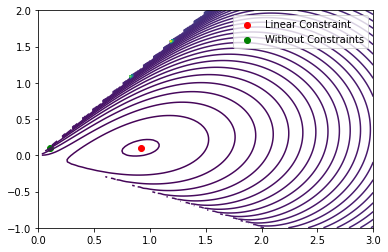

In [229]:
from scipy.optimize import least_squares, minimize, optimize
from scipy.optimize import LinearConstraint
from scipy.optimize import BFGS
import numpy as np
from matplotlib import pyplot as plt


def f(p):
    return p[0] ** 2 + p[1] ** 2 - np.log(4 * p[0] - 3 * p[1]) * np.sqrt(1 * p[0] + 2 * p[1])


def f_jac(p):
     return optimize.approx_fprime(p, f, 0.0001)


linear_constr = [LinearConstraint([1, 2], 0, np.inf), LinearConstraint([4, -3], 0, np.inf)]

x0 = np.array([0.1, 0.1])
res = minimize(f, x0, method='trust-constr', jac=f_jac, hess=BFGS(),
               constraints=linear_constr, options={"disp":True})
res1 = minimize(f, x0, method='trust-constr', jac=f_jac, hess=BFGS(), options={"disp":True})

number_points = 100j

x, y = np.mgrid[0:3:number_points, -1:2:number_points]

plt.contour(x, y, f([x, y]), levels=200, c='c')
plt.scatter(*res.x,c="r",label="Linear Constraint")
plt.scatter(*res1.x,c="g",label="Without Constraints")
plt.legend()
plt.show()